# Блокнот для написания обработки данных (transform), полученных с newsApi

## Возможные операции трансформации данных:
- Очистка данных (удаление неиспользуемых признаков, дубликатов, выбросов)
- Переформатирование (форматирование данных с разных источников. Форматы дат, валюты и тп)
- Извлечение признаков (создание новых признаков на основе существующих)
- Агрегация (получение необходимых показателей)
- Объединение (объединение данных с нескольких источников)
- Фильтрация (исключение ненужных категорий из набора данных)

In [2]:
import re
import pandas as pd
import nltk
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer


## 1. Импорт данных

In [5]:
csv_data_path = "data_apple.csv"

In [6]:
data = pd.read_csv(csv_data_path, index_col=0)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494 entries, 0 to 493
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       478 non-null    object
 1   title        494 non-null    object
 2   description  486 non-null    object
 3   url          494 non-null    object
 4   urlToImage   486 non-null    object
 5   publishedAt  494 non-null    object
 6   content      494 non-null    object
 7   source.id    29 non-null     object
 8   source.name  494 non-null    object
dtypes: object(9)
memory usage: 38.6+ KB


In [8]:
data.isnull().sum()

author          16
title            0
description      8
url              0
urlToImage       8
publishedAt      0
content          0
source.id      465
source.name      0
dtype: int64

In [9]:
data.columns

Index(['author', 'title', 'description', 'url', 'urlToImage', 'publishedAt',
       'content', 'source.id', 'source.name'],
      dtype='object')

In [10]:
data.head(3)

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
0,Emma Roth,Apple reportedly challenges the UK’s secretive...,Apple is pushing back against the UK’s secret ...,https://www.theverge.com/news/623977/apple-uk-...,https://platform.theverge.com/wp-content/uploa...,2025-03-04T18:29:39Z,"Apple is appealing the UKs backdoor order, acc...",the-verge,The Verge
1,Brenda Stolyar,"Apple 11-inch and 13-inch iPad Air : Price, Sp...",The 11-inch and 13-inch tablets have the same ...,https://www.wired.com/story/apple-new-ipad-air...,https://media.wired.com/photos/67c71913d63ae42...,2025-03-04T15:46:35Z,Less than a year after upgrading its iPad Air ...,wired,Wired
2,Brittany Vincent,Apple AirTag 4-Pack Drops to Below $70 on Amaz...,Why buy one? Apple AirTag 4-Pack is a way bett...,https://gizmodo.com/apple-airtag-4-pack-drops-...,https://gizmodo.com/app/uploads/2025/02/4airta...,2025-03-05T13:10:16Z,Looking to stop losing your stuff? Apple’s Air...,NaN,Gizmodo.com


## 2. Предобработка

### 2.1 Работа с пропущенными значениями

In [11]:
data.dropna(subset=["title", "content"], inplace=True)

In [12]:
data[data["author"].isnull()].head()

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
14,NaN,"Apple introduces new iPad Air with M3 chip, Ap...",NaN,https://consent.yahoo.com/v2/collectConsent?se...,NaN,2025-03-04T15:42:05Z,"If you click 'Accept all', we and our partners...",NaN,Yahoo Entertainment
38,NaN,"Novo Nordisk's Wegovy, Apple Air, Palantir: To...",NaN,https://consent.yahoo.com/v2/collectConsent?se...,NaN,2025-03-05T16:37:35Z,"If you click 'Accept all', we and our partners...",NaN,Yahoo Entertainment
46,NaN,Apple M3 Ultra,"Apple today announced M3 Ultra, offering the m...",https://www.apple.com/newsroom/2025/03/apple-r...,https://www.apple.com/newsroom/images/2025/03/...,2025-03-05T13:59:50Z,"March 5, 2025\r\nPRESS RELEASE\r\nApple reveal...",NaN,Apple Newsroom
49,NaN,Apple introduces iPad Air with powerful M3 chi...,"Apple today introduced the new iPad Air, power...",https://www.apple.com/newsroom/2025/03/apple-i...,https://www.apple.com/newsroom/images/2025/03/...,2025-03-04T14:02:18Z,"March 4, 2025\r\nPRESS RELEASE\r\nApple introd...",NaN,Apple Newsroom
88,NaN,"Apple unveils new Mac Studio, the most powerfu...","Apple today announced the new Mac Studio, the ...",https://www.apple.com/newsroom/2025/03/apple-u...,https://www.apple.com/newsroom/images/2025/03/...,2025-03-05T14:00:57Z,"March 5, 2025\r\nPRESS RELEASE\r\nApple unveil...",NaN,Apple Newsroom


In [13]:
data.dropna(subset=["author"], inplace=True)

Была мысль заменить пустых author на Unknown, но данные записи, как видно, не хранят полезную информацию, поэтому удалим

### 2.2 Дубликаты

In [14]:
data.duplicated(subset=["title", "content"]).any()

np.True_

Имеются дубликаты, необходимо удалить

In [15]:
data[data.duplicated(subset=["title", "content"])]

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
295,Nathan Le Gohlisse,iPhone et iPad : la honte des versions 64 Go e...,Apple a officiellement tiré un trait sur les m...,https://www.frandroid.com/marques/apple/253033...,https://c0.lestechnophiles.com/images.frandroi...,2025-03-05T10:47:41Z,Apple a officiellement tiré un trait sur les m...,NaN,Frandroid


In [16]:
data.drop_duplicates(subset=["title", "content"], inplace=True)

### 2.3 Предобработка текста

In [17]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
def clean_text(text):
    """
    Функция очистки текста
    Удаляет лишние пробелы и символы переноса строк и табуляции
    Оставляет только буквы и цифры

    Args:
        text (_type_): Исходный текст

    Returns:
        _type_: Очищенный текст
    """

    if not isinstance(text, str):
        return ""
    text = re.sub(r"\s+", " ", text) # удаляем символы табуляции и переносов строк
    text = re.sub(r'\[\+\d+ chars\]', '', text) # удаляем [+123 chars] (есть в каждом content)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)  # оставляем только буквы и цифры
    
    text = text.lower()
    words = word_tokenize(text)  # Токенизация
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Лемматизация
    return " ".join(words)

data["title"] = data["title"].apply(clean_text)
data["description"] = data["description"].apply(clean_text)
data["content"] = data["content"].apply(clean_text)

### 2.4 Преобразование дат

In [19]:
data['publishedAt'] = pd.to_datetime(data['publishedAt'], errors='coerce')

In [20]:
data['date'] = data['publishedAt'].dt.date
data['time'] = data['publishedAt'].dt.time

### 2.5 Фильтрация

In [21]:
data.drop(columns=["urlToImage", "source.id", "source.name"], inplace=True)
data.head(3)

,author,title,description,url,publishedAt,content,date,time
0,Emma Roth,apple reportedly challenge uk secretive encryp...,apple pushing back uk secret order give govern...,https://www.theverge.com/news/623977/apple-uk-...,2025-03-04 18:29:39+00:00,apple appealing uk backdoor order according fi...,2025-03-04,18:29:39
1,Brenda Stolyar,apple 11 inch 13 inch ipad air price spec avai...,11 inch 13 inch tablet look minor boost perfor...,https://www.wired.com/story/apple-new-ipad-air...,2025-03-04 15:46:35+00:00,less year upgrading ipad air m2 chip apple alr...,2025-03-04,15:46:35
2,Brittany Vincent,apple airtag 4 pack drop 70 amazon 18,buy one apple airtag 4 pack way better deal,https://gizmodo.com/apple-airtag-4-pack-drops-...,2025-03-05 13:10:16+00:00,looking stop losing stuff apple airtags become...,2025-03-05,13:10:16


## 3. Какие задачи необходимо решить:
- Подсчет самых частых слов
- Определение тональности
- Определение главных тем

### 3.1 Определение тональности текста

In [26]:

nltk.download('vader_lexicon')


def get_text_sentiment(text: str) -> str:
    """Функция определения тональности текста

    Args:
        text (str): исходный текст

    Returns:
        str: тональность (neg, neu, pos, compound)
    """
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    return max(sentiment_scores, key=sentiment_scores.get)

data["sentiment"] = data["description"].apply(get_text_sentiment)
data.head(3)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,author,title,description,url,publishedAt,content,date,time,sentiment
0,Emma Roth,apple reportedly challenge uk secretive encryp...,apple pushing back uk secret order give govern...,https://www.theverge.com/news/623977/apple-uk-...,2025-03-04 18:29:39+00:00,apple appealing uk backdoor order according fi...,2025-03-04,18:29:39,neu
1,Brenda Stolyar,apple 11 inch 13 inch ipad air price spec avai...,11 inch 13 inch tablet look minor boost perfor...,https://www.wired.com/story/apple-new-ipad-air...,2025-03-04 15:46:35+00:00,less year upgrading ipad air m2 chip apple alr...,2025-03-04,15:46:35,neu
2,Brittany Vincent,apple airtag 4 pack drop 70 amazon 18,buy one apple airtag 4 pack way better deal,https://gizmodo.com/apple-airtag-4-pack-drops-...,2025-03-05 13:10:16+00:00,looking stop losing stuff apple airtags become...,2025-03-05,13:10:16,neu


Ниже решил вспомнить различные варианты визуализации данных

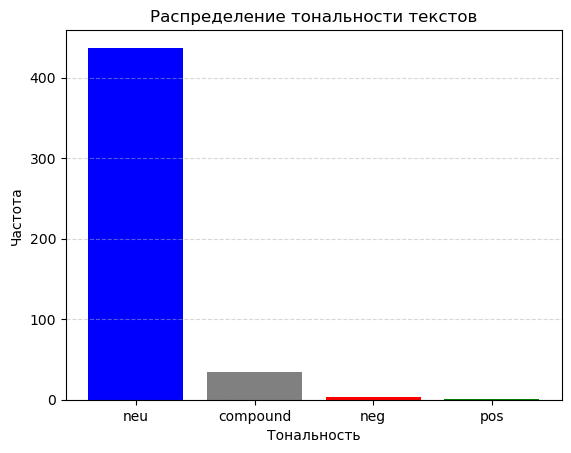

In [27]:
sentiment_counts = data["sentiment"].value_counts()

plt.bar(sentiment_counts.index, sentiment_counts.values, color=["blue", "gray", "red", "green"])
plt.title('Распределение тональности текстов')
plt.xlabel('Тональность')
plt.ylabel('Частота')
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


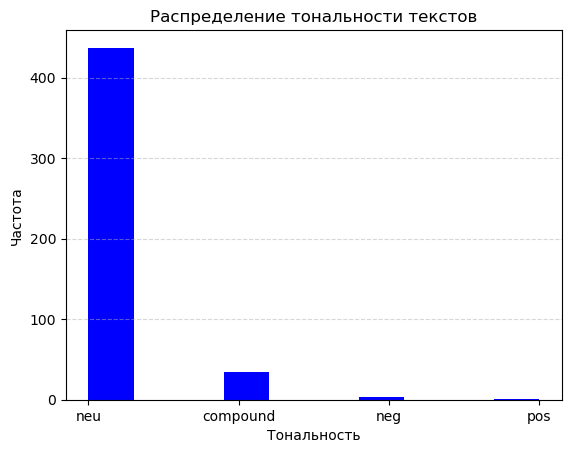

In [28]:
plt.hist(data["sentiment"], color="blue")
plt.title('Распределение тональности текстов')
plt.xlabel('Тональность')
plt.ylabel('Частота')
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

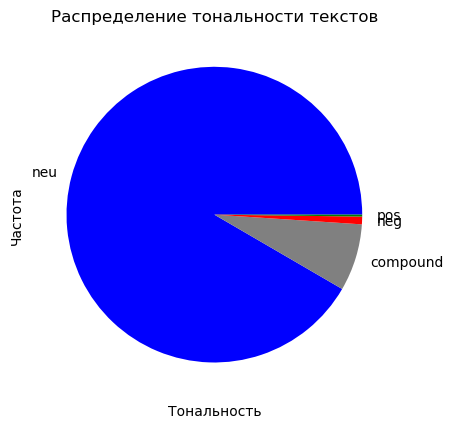

In [29]:
plt.pie(sentiment_counts, labels=sentiment_counts.index, colors=["blue", "gray", "red", "green"])
plt.title('Распределение тональности текстов')
plt.xlabel('Тональность')
plt.ylabel('Частота')
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()